In [167]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sqlalchemy import create_engine, Table, Column, Integer, String, MetaData, Integer, String, insert, select

import statsmodels.formula.api as smf

In [168]:
from sqlalchemy import create_engine, Table, Column, Integer, String, MetaData, Integer, String, insert, select
from SQLalch_helpers import selectPlayerIDsSubQ
from SQLalch_helpers import selectSessionsDataScatter



engine = create_engine("sqlite+pysqlite:///GPSdata1.db", echo=False)

metadata_obj = MetaData()

players_table = Table("players", metadata_obj, autoload_with=engine)
sessions_data_table = Table("sessions_data", metadata_obj, autoload_with=engine)

In [169]:


# get player positions
positions = []

with engine.connect() as conn: 
    
    pos_stm = (
        select(players_table.c.position)
        .group_by(players_table.c.position)
    )

    positions = conn.execute(pos_stm).scalars().all() 

In [170]:
with engine.connect() as conn:
    select_stm_all_data = (
        select(sessions_data_table.c.Distance, sessions_data_table.c.HSR, players_table.c.position)
        .join(players_table, sessions_data_table.c.player_id == players_table.c.id)
    )

    result_all = conn.execute(select_stm_all_data)
    all_data = result_all.mappings().all()

all_df = pd.DataFrame(all_data)

In [171]:
all_df

,Distance,HSR,position
0,9516.8,282.8,CB
1,9579.7,465.3,CB
2,9167.9,249.9,CB
3,9826.8,385.1,CB
4,9756.8,440.9,CB
...,...,...,...
558,11572.3,863.8,FWD
559,10935.5,830.9,FWD
560,12110.2,1137.9,FWD
561,11278.4,810.2,FWD


In [172]:
model = smf.mixedlm("HSR ~ Distance",
                    all_df,
                    groups= "position").fit()


In [173]:
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM   Dependent Variable:   HSR       
No. Observations:   563       Method:               REML      
No. Groups:         4         Scale:                17106.5597
Min. group size:    98        Log-Likelihood:       -3550.0053
Max. group size:    185       Converged:            Yes       
Mean group size:    140.8                                     
--------------------------------------------------------------
               Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
--------------------------------------------------------------
Intercept     -786.354   92.990 -8.456 0.000 -968.611 -604.097
Distance         0.131    0.007 18.341 0.000    0.117    0.145
position Var 12438.632   78.653                               
==============================================================

"""

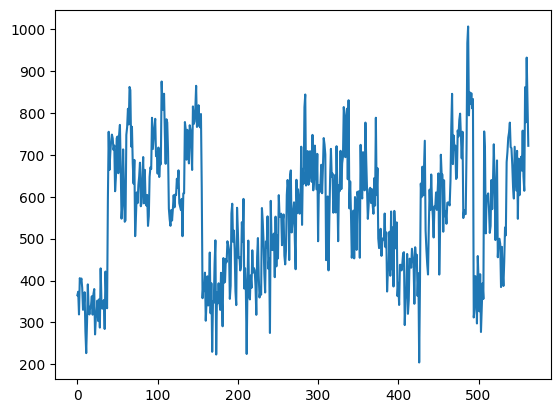

In [174]:
plt.plot(model.fittedvalues)

In [175]:
all_df["fitted"] = model.fittedvalues

In [176]:
all_df

,Distance,HSR,position,fitted
0,9516.8,282.8,CB,364.895382
1,9579.7,465.3,CB,373.161147
2,9167.9,249.9,CB,319.046013
3,9826.8,385.1,CB,405.632855
4,9756.8,440.9,CB,396.434071
...,...,...,...,...
558,11572.3,863.8,FWD,861.607545
559,10935.5,830.9,FWD,777.924890
560,12110.2,1137.9,FWD,932.293632
561,11278.4,810.2,FWD,822.985792


In [177]:
print(all_df["position"][0])

CB


In [178]:
def min_SSE_given_m(m:float, x: np.ndarray, y: np.ndarray) -> float:

    assert x.shape == y.shape
    assert x.ndim == 1

    sigma_y = np.sum(y)
    sigma_x = np.sum(x)
    n = x.shape[0]

    return (sigma_y - m * (sigma_x)) / n # = c

m_all: 0.12713293548554247
c_pos: -844.8862573950977
c_pos: -826.663071875547
c_pos: -681.5124676603633
c_pos: -614.5980869653238


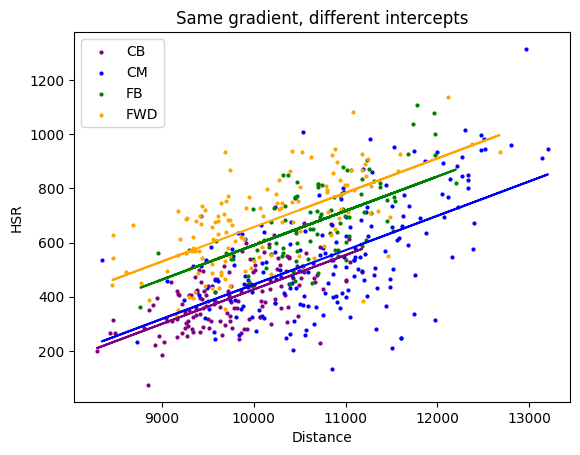

In [179]:
with engine.connect() as conn:
    select_stm_all_data = (
        select(sessions_data_table.c.Distance, sessions_data_table.c.HSR)
    )

    result_all = conn.execute(select_stm_all_data)
    all_data = result_all.mappings().all()

nall_df = pd.DataFrame(all_data)
x_all = nall_df["Distance"].values
y_all = nall_df["HSR"].values


m_all = np.polynomial.polynomial.polyfit(x_all, y_all, 1)[1] # m
print(f"m_all: {m_all}")


colours = ["purple", "blue", "green", "orange"]

for i, position in enumerate(positions):
    pos_subQ = selectPlayerIDsSubQ(position, players_table)
    measure_columns = sessions_data_table.columns
    pos_data = selectSessionsDataScatter(pos_subQ, measure_columns, sessions_data_table)
    pos_df = pd.DataFrame(pos_data)
    x_pos = pos_df["Distance"].values
    y_pos = pos_df["HSR"].values

    c = min_SSE_given_m(m_all, x_pos, y_pos)
    print(f"c_pos: {c}")
    lobf_position = np.polynomial.polynomial.Polynomial((c, m_all))

    if all_df["position"][i] == position:
        plt.plot(x_pos[i], all_df["fitted"][i])

    plt.scatter(x_pos, y_pos, color=colours[i], label = positions[i], s=4)
    plt.plot(x_pos, lobf_position(x_pos), color=colours[i])
    

plt.legend()
plt.title("Same gradient, different intercepts")
plt.xlabel("Distance")
plt.ylabel("HSR")
plt.show()

In [186]:
def min_SSE_given_c(c:float, x: np.ndarray, y: np.ndarray) -> float:

    assert x.shape == y.shape
    assert x.ndim == 1

    sigma_x = np.sum(x)
    sigma_xy = np.sum(x * y)
    sigma_xx = np.sum(x * x)

    return (sigma_xy - (c * sigma_x)) / sigma_xx
    


c_all: 0
m_pos: 0.040834752086969614
m_pos: 0.05163610189478591
m_pos: 0.06371994887345873
m_pos: 0.06670612473000691


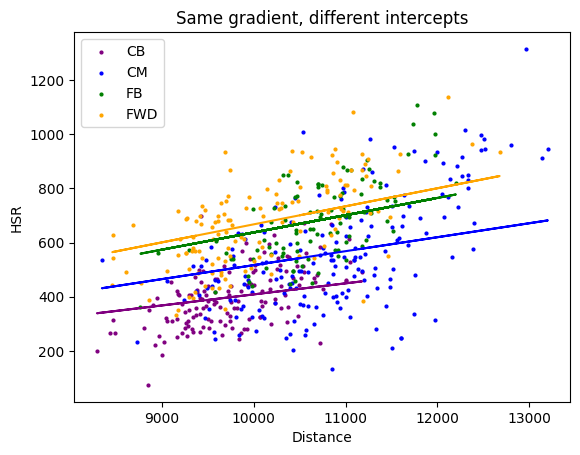

In [189]:
with engine.connect() as conn:
    select_stm_all_data = (
        select(sessions_data_table.c.Distance, sessions_data_table.c.HSR)
    )

    result_all = conn.execute(select_stm_all_data)
    all_data = result_all.mappings().all()

nall_df = pd.DataFrame(all_data)
x_all = nall_df["Distance"].values
y_all = nall_df["HSR"].values

c_all = 0
print(f"c_all: {c_all}")


colours = ["purple", "blue", "green", "orange"]

for i, position in enumerate(positions):
    pos_subQ = selectPlayerIDsSubQ(position, players_table)
    measure_columns = sessions_data_table.columns
    pos_data = selectSessionsDataScatter(pos_subQ, measure_columns, sessions_data_table)
    pos_df = pd.DataFrame(pos_data)
    x_pos = pos_df["Distance"].values
    y_pos = pos_df["HSR"].values

    m = min_SSE_given_c(c_all, x_pos, y_pos)
    print(f"m_pos: {m}")
    lobf_position = np.polynomial.polynomial.Polynomial((c_all, m))

    if all_df["position"][i] == position:
        plt.plot(x_pos[i], all_df["fitted"][i])

    plt.scatter(x_pos, y_pos, color=colours[i], label = positions[i], s=4)
    plt.plot(x_pos, lobf_position(x_pos), color=colours[i])
    

plt.legend()
plt.title("Same gradient, different intercepts")
plt.xlabel("Distance")
plt.ylabel("HSR")
plt.show()